## Acquiring and Processing Information on the World's Largest Banks

# Summary of Steps
1. Define the log_progress() function for logging.
2. Extract data from the URL and log progress.
3. Transform the extracted data and log progress.
4. Load the transformed data to a CSV file and log progress.
5. Load the data to a database and log progress.
6. Execute queries on the database and log progress.
7. Verify the log entries.

Task 1: Log Progress
- First, let's create the log_progress() function and ensure that it logs messages to the code_log.txt file with the correct format.

In [10]:
import logging
from datetime import datetime

# Configure logging
logging.basicConfig(filename='code_log.txt', level=logging.INFO, format='%(asctime)s : %(message)s')

def log_progress(message):
    ''' This function logs the mentioned message of a given stage of the code execution to a log file. Function returns nothing'''
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open('code_log.txt', 'a') as log_file:
        log_file.write(f"{timestamp} : {message}\n")

# Initial log entry
log_progress("Preliminaries complete. Initiating ETL process")


Task 2: Extract Data
- Next, we will write the extract() function and log the completion of data extraction.

In [11]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

def extract(url, table_attribs):
    ''' This function aims to extract the required information from the website and save it to a data frame. The function returns the data frame for further processing. '''
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table with the provided attributes
    table = soup.find('table', table_attribs)

    # Extract table headers and rows
    headers = [header.text.strip() for header in table.find_all('th')]
    rows = table.find_all('tr')

    # Extract data into a list of dictionaries
    data = []
    for row in rows[1:]:  # Skip header row
        cells = row.find_all('td')
        if len(cells) > 1:
            data.append({
                'Name': cells[1].text.strip(),
                'MC_USD_Billion': float(cells[2].text.strip().replace(',', '').replace('\n', ''))
            })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    log_progress("Data extraction complete. Initiating Transformation process")
    return df

# Execute the function and verify the output
url = "https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks"
table_attribs = {'class': 'wikitable'}
df_extracted = extract(url, table_attribs)
print(df_extracted)


                                      Name  MC_USD_Billion
0                           JPMorgan Chase          432.92
1                          Bank of America          231.52
2  Industrial and Commercial Bank of China          194.56
3               Agricultural Bank of China          160.68
4                                HDFC Bank          157.91
5                              Wells Fargo          155.87
6                        HSBC Holdings PLC          148.90
7                           Morgan Stanley          140.83
8                  China Construction Bank          139.82
9                            Bank of China          136.81


Task 3: Transform Data
- We will write the transform() function and log the completion of data transformation.

In [12]:
def transform(df, csv_path):
    ''' This function accesses the CSV file for exchange rate information, and adds three columns to the data frame, each containing the transformed version of Market Cap column to respective currencies'''
    exchange_rates = pd.read_csv(csv_path)

    # Extract exchange rates
    usd_to_gbp = exchange_rates.loc[exchange_rates['Currency'] == 'GBP', 'Rate'].values[0]
    usd_to_eur = exchange_rates.loc[exchange_rates['Currency'] == 'EUR', 'Rate'].values[0]
    usd_to_inr = exchange_rates.loc[exchange_rates['Currency'] == 'INR', 'Rate'].values[0]

    # Add new columns
    df['MC_GBP_Billion'] = (df['MC_USD_Billion'] * usd_to_gbp).round(2)
    df['MC_EUR_Billion'] = (df['MC_USD_Billion'] * usd_to_eur).round(2)
    df['MC_INR_Billion'] = (df['MC_USD_Billion'] * usd_to_inr).round(2)

    log_progress("Data transformation complete. Initiating Loading process")
    return df

# Execute the function and verify the output
csv_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv"
df_transformed = transform(df_extracted, csv_path)
print(df_transformed)


                                      Name  MC_USD_Billion  MC_GBP_Billion  \
0                           JPMorgan Chase          432.92          346.34   
1                          Bank of America          231.52          185.22   
2  Industrial and Commercial Bank of China          194.56          155.65   
3               Agricultural Bank of China          160.68          128.54   
4                                HDFC Bank          157.91          126.33   
5                              Wells Fargo          155.87          124.70   
6                        HSBC Holdings PLC          148.90          119.12   
7                           Morgan Stanley          140.83          112.66   
8                  China Construction Bank          139.82          111.86   
9                            Bank of China          136.81          109.45   

   MC_EUR_Billion  MC_INR_Billion  
0          402.62        35910.71  
1          215.31        19204.58  
2          180.94        16138.75

Task 4: Load Data to CSV
- We will write the load_to_csv() function and log the completion of data loading to CSV.

In [13]:
def load_to_csv(df, output_path):
    ''' This function saves the final data frame as a CSV file in the provided path. Function returns nothing.'''
    df.to_csv(output_path, index=False)
    log_progress("Data saved to CSV file")

# Execute the function and verify the output
output_csv_path = './Largest_banks_data.csv'
load_to_csv(df_transformed, output_csv_path)


Task 5: Load Data to Database
- We will write the load_to_db() function, initiate a connection, log the completion of data loading to the database, and log the closure of the connection.

In [14]:
import sqlite3

def load_to_db(df, sql_connection, table_name):
    ''' This function saves the final data frame to a database table with the provided name. Function returns nothing.'''
    df.to_sql(table_name, sql_connection, if_exists='replace', index=False)
    log_progress("Data loaded to Database as a table, Executing queries")

# Execute the function and verify the output
log_progress("SQL Connection initiated")
conn = sqlite3.connect('Banks.db')
load_to_db(df_transformed, conn, 'Largest_banks')


Task 6: Run Queries
- We will write the run_queries() function and log the completion of the query execution.

In [15]:
def run_query(query_statement, sql_connection):
    ''' This function runs the query on the database table and prints the output on the terminal. Function returns nothing. '''
    cursor = sql_connection.cursor()
    cursor.execute(query_statement)
    results = cursor.fetchall()
    for result in results:
        print(result)
    log_progress("Process Complete")

# Example queries
queries = [
    "SELECT Name, MC_USD_Billion FROM Largest_banks ORDER BY MC_USD_Billion DESC LIMIT 5",
    "SELECT AVG(MC_EUR_Billion) FROM Largest_banks"
]

# Execute the function and verify the output
for query in queries:
    run_query(query, conn)

# Close the connection
conn.close()
log_progress("Server Connection closed")


('JPMorgan Chase', 432.92)
('Bank of America', 231.52)
('Industrial and Commercial Bank of China', 194.56)
('Agricultural Bank of China', 160.68)
('HDFC Bank', 157.91)
(176.68300000000005,)


Task 7: Verify Log Entries
- Finally, we will verify the log entries by checking the contents of the code_log.txt file.

In [16]:
def verify_logs(log_file):
    with open(log_file, 'r') as file:
        logs = file.readlines()
    return logs

# Execute the function and verify the output
log_file = 'code_log.txt'
log_entries = verify_logs(log_file)
for entry in log_entries:
    print(entry.strip())


2024-06-07 10:18:29 : Preliminaries complete. Initiating ETL process
2024-06-07 10:19:17 : Data extraction complete. Initiating Transformation process
2024-06-07 10:19:37 : Data transformation complete. Initiating Loading process
2024-06-07 10:20:01 : Data saved to CSV file
2024-06-07 10:20:23 : SQL Connection initiated
2024-06-07 10:20:23 : Data loaded to Database as a table, Executing queries
2024-06-07 10:20:52 : Process Complete
2024-06-07 10:20:52 : Server Connection closed
2024-06-07 10:24:50 : Preliminaries complete. Initiating ETL process
2024-06-07 10:24:53 : Data extraction complete. Initiating Transformation process
2024-06-07 10:24:58 : Data transformation complete. Initiating Loading process
2024-06-07 10:25:07 : Data saved to CSV file
2024-06-07 10:25:18 : SQL Connection initiated
2024-06-07 10:25:18 : Data loaded to Database as a table, Executing queries
2024-06-07 10:25:27 : Process Complete
2024-06-07 10:25:27 : Process Complete
2024-06-07 10:25:27 : Server Connection 

------------------------------

### Charts
1. Bar Chart: Market Capitalization of the Top 10 Largest Banks
- A bar chart is an excellent way to compare the market capitalization of the top 10 largest banks. This can be visualized in USD, GBP, EUR, or INR.
2. Pie Chart: Market Capitalization Distribution
- A pie chart can show the distribution of the total market capitalization among the top 10 banks.
3. Line Chart: Trend of Market Capitalization Across Currencies
- Trend of Market Capitalization Across Currencies
4. Stacked Bar Chart: Market Capitalization Breakdown
- Market Capitalization Breakdown by Currency

In [17]:
import matplotlib.pyplot as plt

# Data for charts
top_10_banks = df_transformed.head(10)

1. ---------------------
Bar Charts: Visualize the market capitalization of the top 10 largest banks in USD, GBP, EUR, and INR.

Bar Chart: Market Capitalization in USD

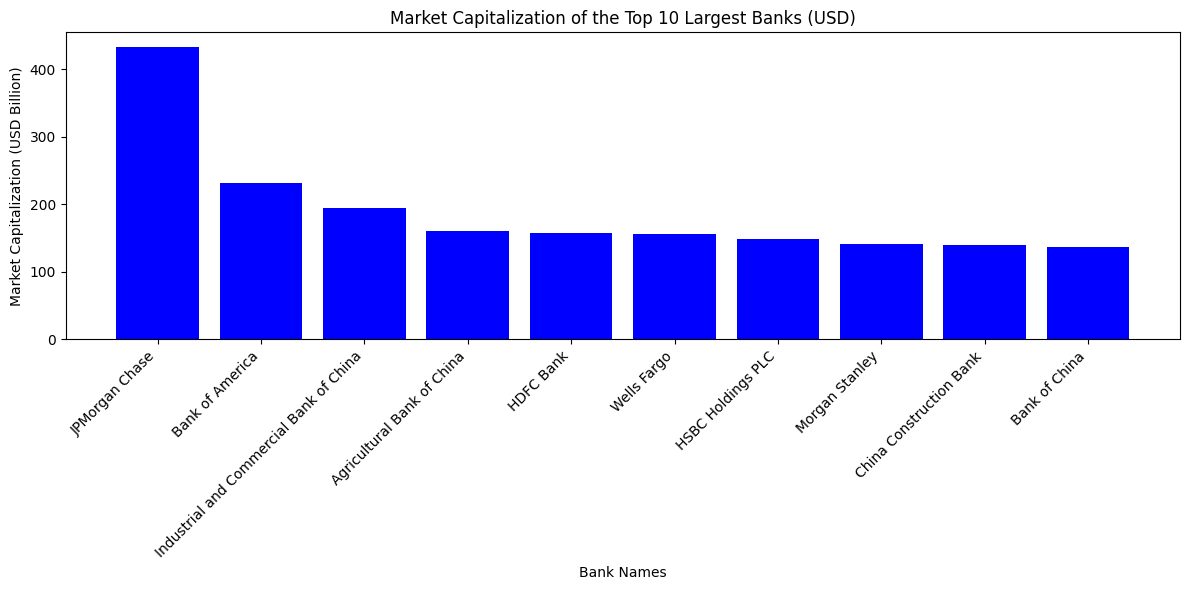

In [18]:
# Bar Chart: Market Capitalization in USD
plt.figure(figsize=(12, 6))
plt.bar(top_10_banks['Name'], top_10_banks['MC_USD_Billion'], color='blue')
plt.xlabel('Bank Names')
plt.ylabel('Market Capitalization (USD Billion)')
plt.title('Market Capitalization of the Top 10 Largest Banks (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Market_Capitalization_Top_10_Banks_USD.png')
plt.show()

Bar Chart: Market Capitalization in GBP

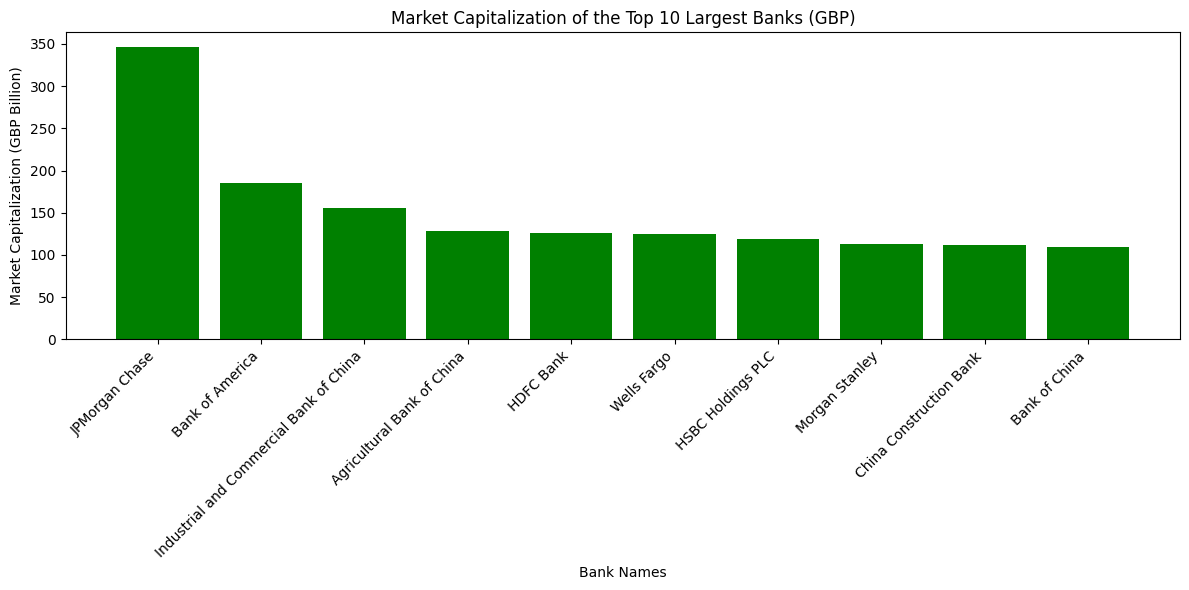

In [19]:
# Bar Chart: Market Capitalization in GBP
plt.figure(figsize=(12, 6))
plt.bar(top_10_banks['Name'], top_10_banks['MC_GBP_Billion'], color='green')
plt.xlabel('Bank Names')
plt.ylabel('Market Capitalization (GBP Billion)')
plt.title('Market Capitalization of the Top 10 Largest Banks (GBP)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Market_Capitalization_Top_10_Banks_GBP.png')
plt.show()

Bar Chart: Market Capitalization in EUR

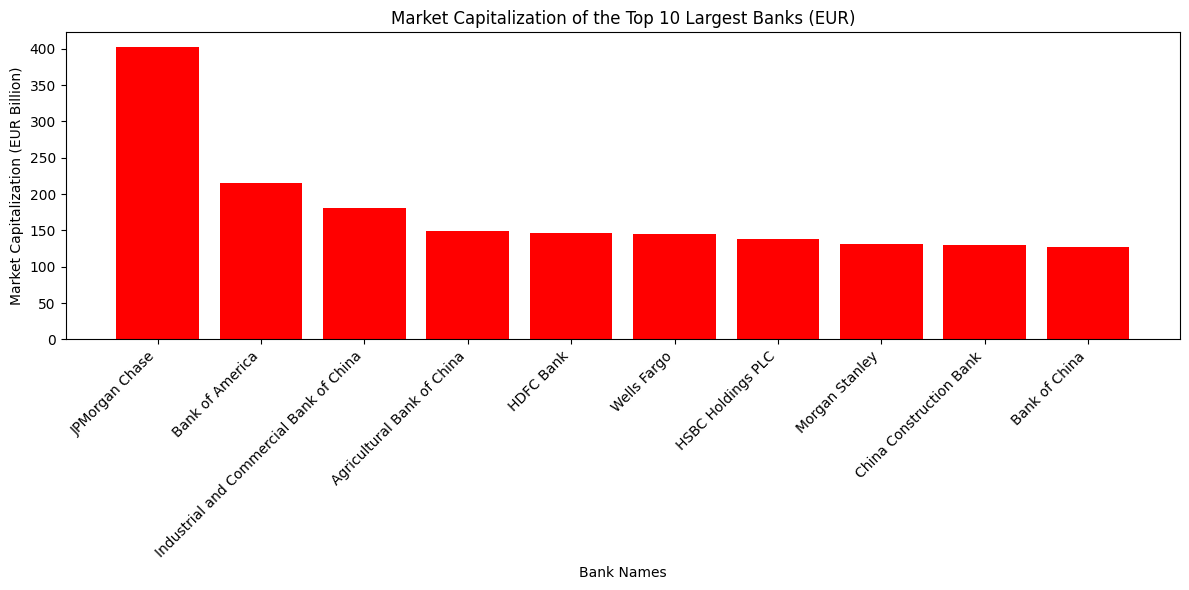

In [20]:
# Bar Chart: Market Capitalization in EUR
plt.figure(figsize=(12, 6))
plt.bar(top_10_banks['Name'], top_10_banks['MC_EUR_Billion'], color='red')
plt.xlabel('Bank Names')
plt.ylabel('Market Capitalization (EUR Billion)')
plt.title('Market Capitalization of the Top 10 Largest Banks (EUR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Market_Capitalization_Top_10_Banks_EUR.png')
plt.show()

Bar Chart: Market Capitalization in INR

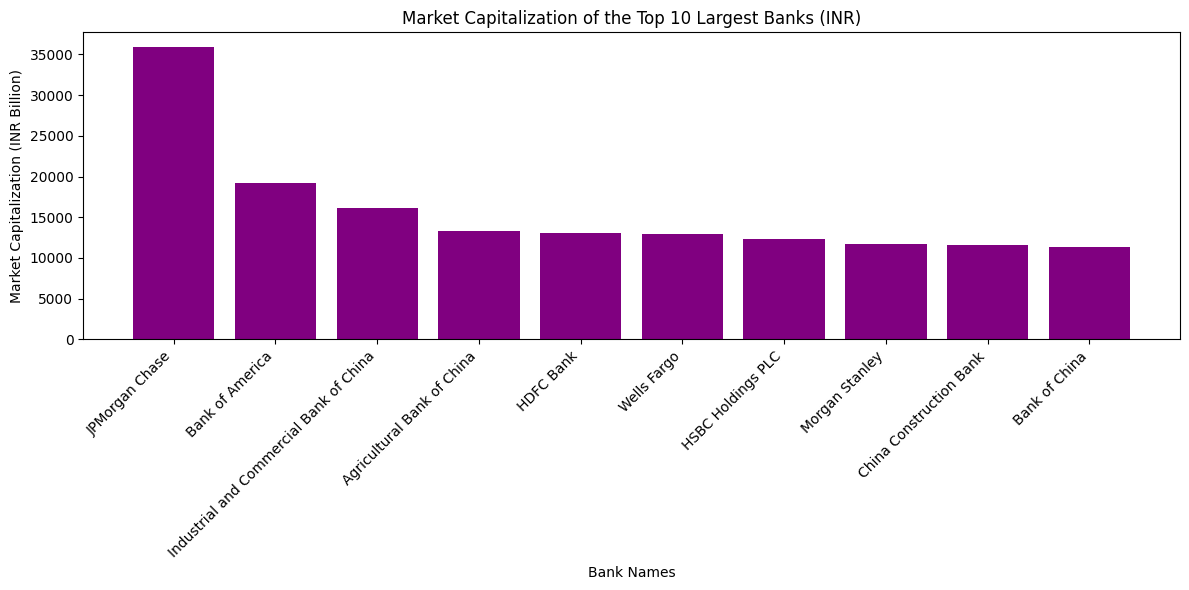

In [21]:
# Bar Chart: Market Capitalization in INR
plt.figure(figsize=(12, 6))
plt.bar(top_10_banks['Name'], top_10_banks['MC_INR_Billion'], color='purple')
plt.xlabel('Bank Names')
plt.ylabel('Market Capitalization (INR Billion)')
plt.title('Market Capitalization of the Top 10 Largest Banks (INR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Market_Capitalization_Top_10_Banks_INR.png')
plt.show()

2. -----------------------
Pie Charts: Show the distribution of market capitalization among the top 10 banks in different currencies.

Pie Chart: Market Capitalization Distribution in USD

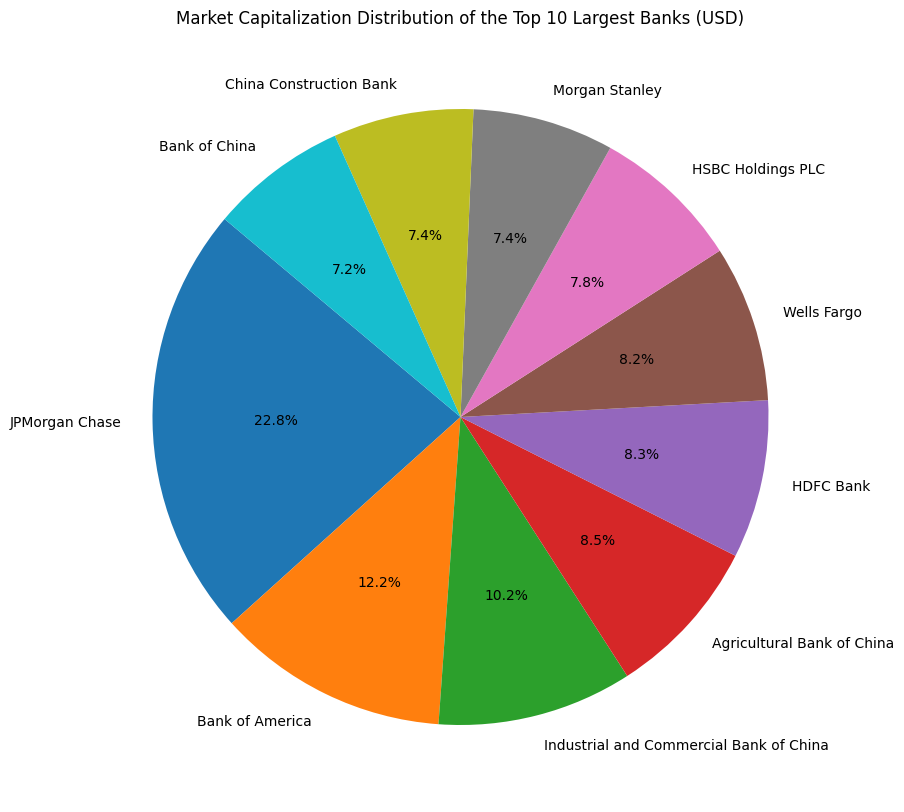

In [23]:
# Pie Chart: Market Capitalization Distribution in USD
plt.figure(figsize=(10, 10))
plt.pie(top_10_banks['MC_USD_Billion'], labels=top_10_banks['Name'], autopct='%1.1f%%', startangle=140)
plt.title('Market Capitalization Distribution of the Top 10 Largest Banks (USD)')
plt.savefig('Market_Capitalization_Distribution_USD.png')
plt.show()

Pie Chart: Market Capitalization Distribution in GBP

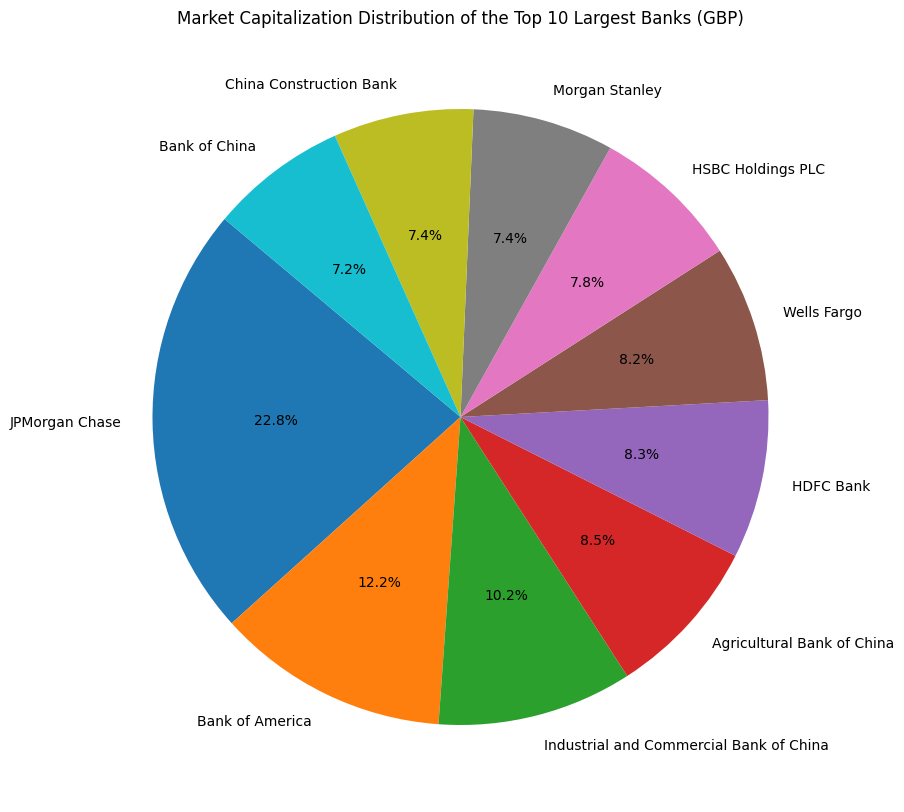

In [24]:
# Pie Chart: Market Capitalization Distribution in GBP
plt.figure(figsize=(10, 10))
plt.pie(top_10_banks['MC_GBP_Billion'], labels=top_10_banks['Name'], autopct='%1.1f%%', startangle=140)
plt.title('Market Capitalization Distribution of the Top 10 Largest Banks (GBP)')
plt.savefig('Market_Capitalization_Distribution_GBP.png')
plt.show()

Pie Chart: Market Capitalization Distribution in EUR

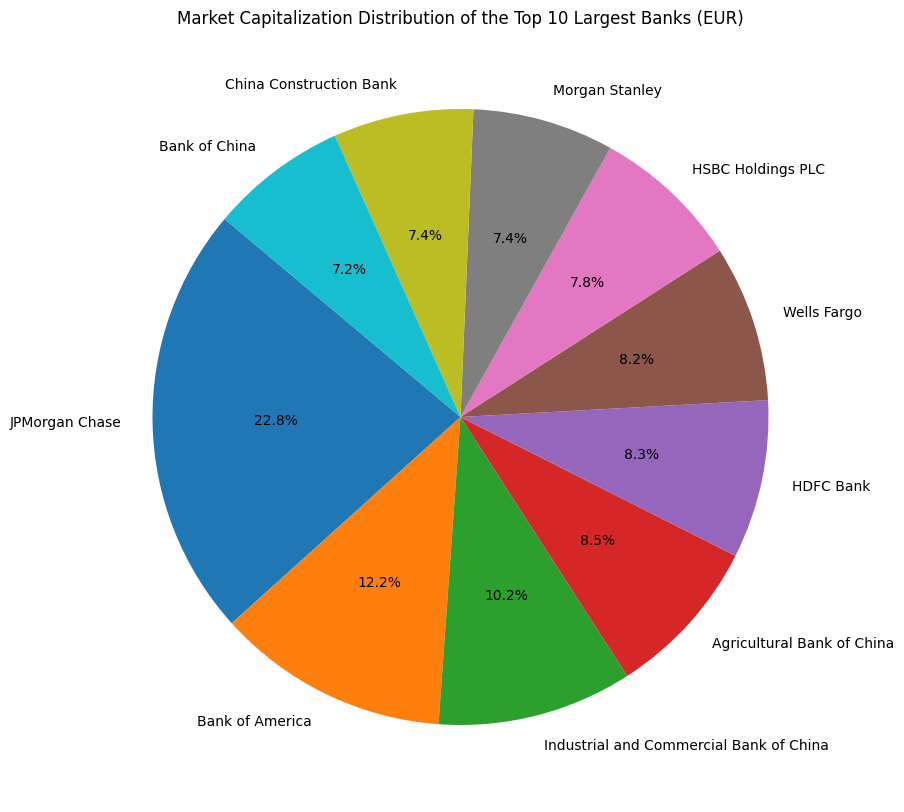

In [25]:
# Pie Chart: Market Capitalization Distribution in EUR
plt.figure(figsize=(10, 10))
plt.pie(top_10_banks['MC_EUR_Billion'], labels=top_10_banks['Name'], autopct='%1.1f%%', startangle=140)
plt.title('Market Capitalization Distribution of the Top 10 Largest Banks (EUR)')
plt.savefig('Market_Capitalization_Distribution_EUR.png')
plt.show()

Pie Chart: Market Capitalization Distribution in INR

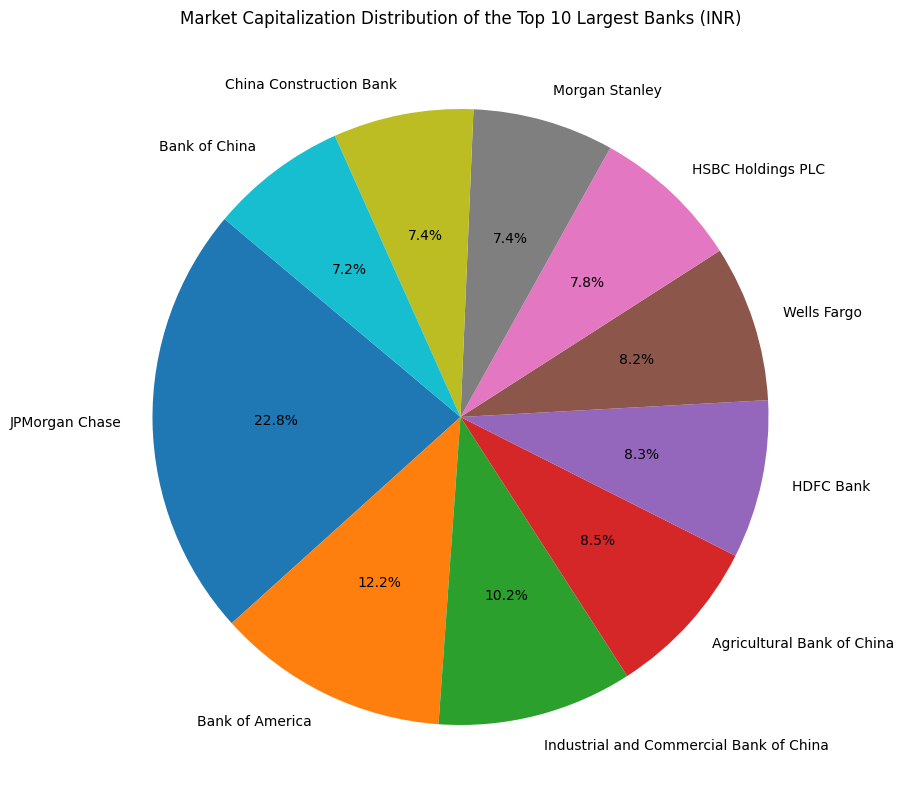

In [26]:
# Pie Chart: Market Capitalization Distribution in INR
plt.figure(figsize=(10, 10))
plt.pie(top_10_banks['MC_INR_Billion'], labels=top_10_banks['Name'], autopct='%1.1f%%', startangle=140)
plt.title('Market Capitalization Distribution of the Top 10 Largest Banks (INR)')
plt.savefig('Market_Capitalization_Distribution_INR.png')
plt.show()

3. -------------------
Line Chart: Trend of Market Capitalization Across Currencies

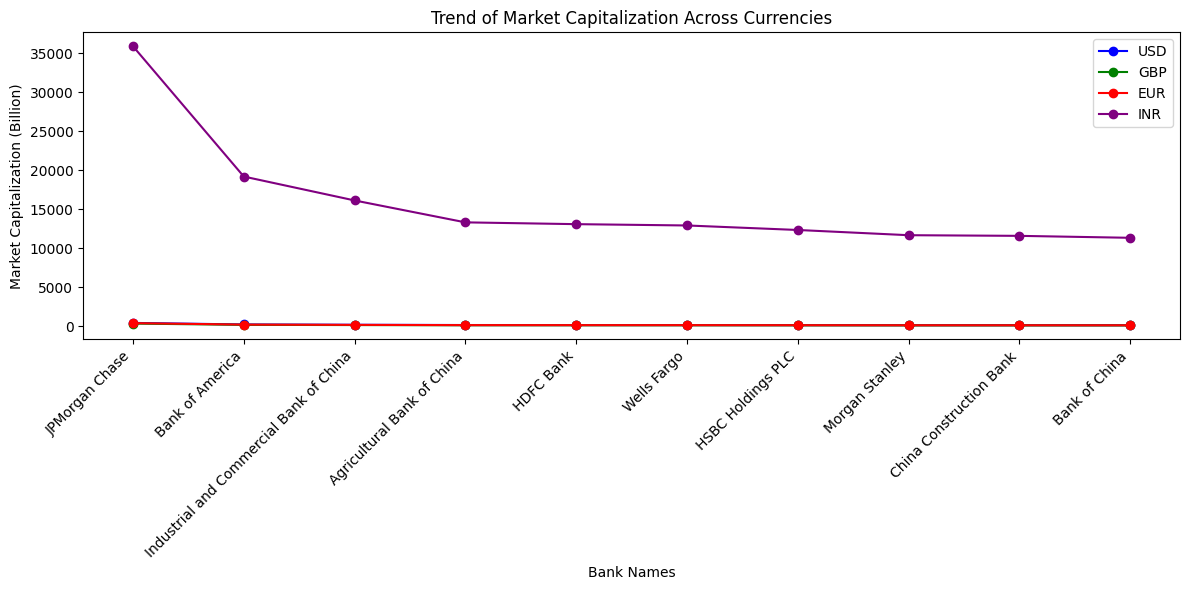

In [27]:
# Line Chart: Trend of Market Capitalization Across Currencies
plt.figure(figsize=(12, 6))
plt.plot(top_10_banks['Name'], top_10_banks['MC_USD_Billion'], marker='o', label='USD', color='blue')
plt.plot(top_10_banks['Name'], top_10_banks['MC_GBP_Billion'], marker='o', label='GBP', color='green')
plt.plot(top_10_banks['Name'], top_10_banks['MC_EUR_Billion'], marker='o', label='EUR', color='red')
plt.plot(top_10_banks['Name'], top_10_banks['MC_INR_Billion'], marker='o', label='INR', color='purple')
plt.xlabel('Bank Names')
plt.ylabel('Market Capitalization (Billion)')
plt.title('Trend of Market Capitalization Across Currencies')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('Trend_Market_Capitalization_Currencies.png')
plt.show()

4. ---------------------------------
Stacked Bar Chart: Market Capitalization Breakdown by Currency

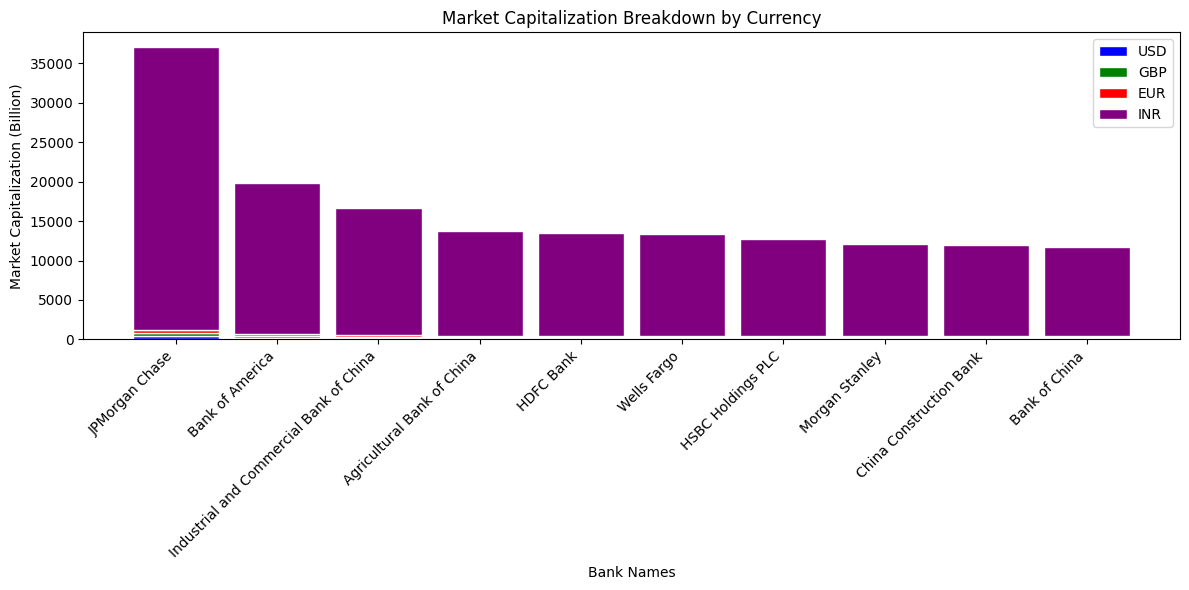

In [28]:
# Stacked Bar Chart: Market Capitalization Breakdown by Currency
plt.figure(figsize=(12, 6))
bar_width = 0.85
bars1 = top_10_banks['MC_USD_Billion']
bars2 = top_10_banks['MC_GBP_Billion']
bars3 = top_10_banks['MC_EUR_Billion']
bars4 = top_10_banks['MC_INR_Billion']

r = range(len(top_10_banks['Name']))

plt.bar(r, bars1, color='blue', edgecolor='white', width=bar_width, label='USD')
plt.bar(r, bars2, bottom=bars1, color='green', edgecolor='white', width=bar_width, label='GBP')
plt.bar(r, bars3, bottom=bars1+bars2, color='red', edgecolor='white', width=bar_width, label='EUR')
plt.bar(r, bars4, bottom=bars1+bars2+bars3, color='purple', edgecolor='white', width=bar_width, label='INR')

plt.xlabel('Bank Names')
plt.ylabel('Market Capitalization (Billion)')
plt.title('Market Capitalization Breakdown by Currency')
plt.xticks(r, top_10_banks['Name'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('Stacked_Market_Capitalization_Currencies.png')
plt.show()